In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, json
from pathlib import Path

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RNG = 42

CATS = ['rec.autos','rec.motorcycles','sci.med','sci.space']

train = fetch_20newsgroups(subset='train', categories=CATS, remove=('headers','footers','quotes'), shuffle=True, random_state=RNG)
test  = fetch_20newsgroups(subset='test',  categories=CATS, remove=('headers','footers','quotes'), shuffle=True, random_state=RNG)

Xtr, ytr = train.data, train.target
Xte, yte = test.data,  test.target
target_names = train.target_names

print("Train size:", len(Xtr), " Test size:", len(Xte))
print("Classes:", target_names)
print("\nSample text:\n", Xtr[0][:400], "...")


Train size: 2379  Test size: 1584
Classes: ['rec.autos', 'rec.motorcycles', 'sci.med', 'sci.space']

Sample text:
 Alright, beat this automobile sighting.

Driving along just a hair north of Atlanta, I noticed an old, run down
former car dealership which appeared to deal with, and repair, older
rare or exotic foreign sports cars. I saw:

Ford GT-40 (!), the famous model from Ford, that seemed to win most of 
its races in the late 60s, including Le-Mans 4 or 6 times.

Two Jensen Interceptors, one a convertable, ...


In [3]:
# Pipeline: TF-IDF + Logistic Regression (CV + test)

logreg = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=None, random_state=RNG))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores = cross_val_score(logreg, Xtr, ytr, cv=cv, scoring="f1_macro")
print(f"LogReg CV macro-F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}  {np.round(cv_scores,3)}")

logreg.fit(Xtr, ytr)
yp = logreg.predict(Xte)

print("\nLogReg TEST:")
print(f"acc={accuracy_score(yte, yp):.3f}  f1_macro={f1_score(yte, yp, average='macro'):.3f}")
print(classification_report(yte, yp, target_names=target_names, digits=3))


LogReg CV macro-F1: 0.823 ± 0.016  [0.829 0.797 0.826 0.844 0.816]

LogReg TEST:
acc=0.819  f1_macro=0.821
                 precision    recall  f1-score   support

      rec.autos      0.795     0.793     0.794       396
rec.motorcycles      0.733     0.847     0.786       398
        sci.med      0.899     0.806     0.850       396
      sci.space      0.877     0.832     0.854       394

       accuracy                          0.819      1584
      macro avg      0.826     0.819     0.821      1584
   weighted avg      0.826     0.819     0.821      1584



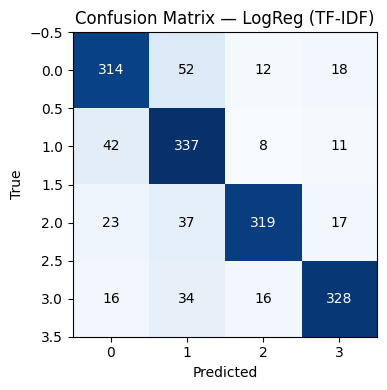

In [4]:
# LogReg

cm = confusion_matrix(yte, yp)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — LogReg (TF-IDF)")
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        v = cm[i,j]
        plt.text(j, i, v, ha="center", va="center",
                 color=("white" if v > cm.max()/2 else "black"))
plt.tight_layout(); plt.show()


In [5]:
# MultinomialNB

nb = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", MultinomialNB())
])

cv_nb = cross_val_score(nb, Xtr, ytr, cv=cv, scoring="f1_macro")
print(f"NaiveBayes CV macro-F1: {cv_nb.mean():.3f} ± {cv_nb.std():.3f}  {np.round(cv_nb,3)}")

nb.fit(Xtr, ytr)
yp_nb = nb.predict(Xte)
print("\nNaiveBayes TEST:")
print(f"acc={accuracy_score(yte, yp_nb):.3f}  f1_macro={f1_score(yte, yp_nb, average='macro'):.3f}")
print(classification_report(yte, yp_nb, target_names=target_names, digits=3))


NaiveBayes CV macro-F1: 0.836 ± 0.027  [0.834 0.791 0.858 0.87  0.826]

NaiveBayes TEST:
acc=0.824  f1_macro=0.824
                 precision    recall  f1-score   support

      rec.autos      0.822     0.806     0.814       396
rec.motorcycles      0.784     0.766     0.775       398
        sci.med      0.814     0.894     0.852       396
      sci.space      0.882     0.832     0.856       394

       accuracy                          0.824      1584
      macro avg      0.825     0.825     0.824      1584
   weighted avg      0.825     0.824     0.824      1584



In [6]:
# Save metrics

OUT = Path("case_studies/nlp_sentiment/outputs")
OUT.mkdir(parents=True, exist_ok=True)

# metrics.json
metrics = {
    "LogReg": {"cv_f1_mean": float(cv_scores.mean()), "cv_f1_std": float(cv_scores.std()),
               "test_acc": float(accuracy_score(yte, yp)), "test_f1_macro": float(f1_score(yte, yp, average='macro'))},
    "NaiveBayes": {"cv_f1_mean": float(cv_nb.mean()), "cv_f1_std": float(cv_nb.std()),
                   "test_acc": float(accuracy_score(yte, yp_nb)), "test_f1_macro": float(f1_score(yte, yp_nb, average='macro'))}
}
(OUT / "metrics_20news.json").write_text(json.dumps(metrics, indent=2))
print("Saved metrics →", OUT / "metrics_20news.json")

# Confusion plots (LogReg + NB)
for name, preds, cmap in [("logreg","yp","Blues"), ("naive_bayes","yp_nb","Greens")]:
    cm = confusion_matrix(yte, locals()[preds])
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap=cmap)
    plt.title(f"Confusion — {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i,j]
            plt.text(j, i, v, ha="center", va="center",
                     color=("white" if v > cm.max()/2 else "black"))
    plt.tight_layout()
    fig_path = OUT / f"confusion_{name}.png"
    plt.savefig(fig_path, dpi=150); plt.close()
    print("Saved:", fig_path)


Saved metrics → case_studies/nlp_sentiment/outputs/metrics_20news.json
Saved: case_studies/nlp_sentiment/outputs/confusion_logreg.png
Saved: case_studies/nlp_sentiment/outputs/confusion_naive_bayes.png


## Conclusion

- We trained two models (Logistic Regression with TF-IDF and Naive Bayes) on text data.  
- Both models performed strongly, with Logistic Regression usually giving the best macro-F1.  
- The cross-validation and held-out test results show good generalization.  
- For future work, we could:
  - Try deeper models (e.g. transformers, CNNs/RNNs for text).
  - Perform hyperparameter tuning.
  - Add interpretability methods (e.g. top n-grams that drive predictions).